# Train Sklearn Models With Simple Pipeline

In this notebook we train Logistic regression and [Huber classifier](https://en.wikipedia.org/wiki/Huber_loss#Variant_for_classification) from sklearn library and compare their perfomance.

In [1]:
import sys

import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

sys.path.append('../..')

from batchflow.models import SklearnModel
from batchflow.opensets import MNIST
from batchflow import B, C, V, D, Pipeline
from batchflow.utils import plot_images_predictions

In [2]:
BATCH_SIZE = 64

# Create dataset

Load MNIST dataset.

In [3]:
dataset = MNIST()

# Initialize models

Initialize both models providing the pipeline config for each of them with the following keys:
* `model_name` 
* `estimator` , that has to be [SGDClassifiers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.predict_proba) instance.
* `vpred_name` - the variable name that contains model's predictions

In [4]:
huber_config = {'model_name': 'huber_model', 
                'estimator': SGDClassifier(loss='modified_huber'),
                'predictions_name': 'huber_predictions',
                'metrics_name': 'huber_metrics'}

log_config = {'model_name': 'log_model', 
              'estimator': SGDClassifier(loss='log'),
              'predictions_name': 'log_predictions',
              'metrics_name': 'log_metrics'}

In [5]:
init_huber_model = Pipeline().init_model('dynamic', SklearnModel, 'huber_model', 
                                 config={'estimator' : C('estimator')})
init_log_model = Pipeline().init_model('dynamic', SklearnModel, 'log_model', 
                                 config={'estimator' : C('estimator')})

# Create train pipelines

Training pipeline template. We exploit the exact same pipeline various times with different estimators.

Pipeline preprocessing image actions include:
1. Transform images from `PIL.Image` to `np.array`.   
2. Reshape images to `2-dimensional` arrays where the number of rows equal to the batch size.

`Sklearn` models with `partial_fit` attribute support batch wise training and can be integrated into pipeline.

In [8]:
num_classes = dataset.num_classes
train_template = (Pipeline()
                    .to_array()
                    .add_namespace(np)
                    .reshape(B('images'), (B('size'), -1), save_to=B('images'))
                    .train_model(C('model_name'), B.images, B.labels, 
                                classes=list(range(num_classes)))
                    .run_later(BATCH_SIZE, n_iters=10000, drop_last=True, shuffle=True, bar=True)
           ) << dataset.train

Ready to use training pipelines for each model.

In [9]:
huber_train_pipeline = (init_huber_model + train_template) << huber_config
log_train_pipeline = (init_log_model + train_template) << log_config

# Train the models

Run the pipelines.

In [10]:
huber_train_pipeline.run()

100%|██████████| 10000/10000 [00:55<00:00, 180.39it/s]


In [11]:
log_train_pipeline.run()

100%|██████████| 10000/10000 [00:52<00:00, 192.20it/s]


# Test the models

Import trained models from training pipelines.

In [12]:
import_huber_model = Pipeline().import_model('huber_model', huber_train_pipeline)
import_log_model = Pipeline().import_model('log_model', log_train_pipeline)

The same steps of preprocessing images used in test pipelines.   

In [13]:
test_template = (Pipeline()
                    .init_variable(C('metrics_name'), default=[])
                    .init_variable(C('predictions_name'), default=[])
                    .to_array()
                    .add_namespace(np)
                    .reshape(B('images'), (B('size'), -1), save_to=B('images'))
                    .predict_model(C('model_name'), B('images'), save_to=V(C('predictions_name'), mode='w'), proba=True)              
                    .gather_metrics('class', B.labels, V(C('predictions_name')), num_classes=num_classes,
                                     fmt='proba', axis=1, save_to=V(C('metrics_name'), mode='w'))
                    .run_later(200, n_epochs=1, drop_last=False, shuffle=True, bar=True)
                    .reshape(B('images'), (B('size'), 28, 28), save_to=B('images'))
            ) << dataset.test

In [14]:
huber_test_pipeline = (import_huber_model + test_template) << huber_config
log_test_pipeline = (import_log_model + test_template) << log_config

Run test pipelines.

In [ ]:
huber_test_pipeline.run()

In [ ]:
log_test_pipeline.run()

Let's get the accumulated [metrics information](https://analysiscenter.github.io/batchflow/intro/models.html#model-metrics).

In [17]:
log_metrics = log_test_pipeline.v('log_metrics')
huber_metrics = huber_test_pipeline.v('huber_metrics')

In [18]:
log_metrics.evaluate('acc'), huber_metrics.evaluate('acc') 

(0.825, 0.775)

In [19]:
huber_batch = huber_test_pipeline.next_batch(10, shuffle=True)
log_batch = log_test_pipeline.next_batch(10, shuffle=True)

Let's take a look at the predictions.

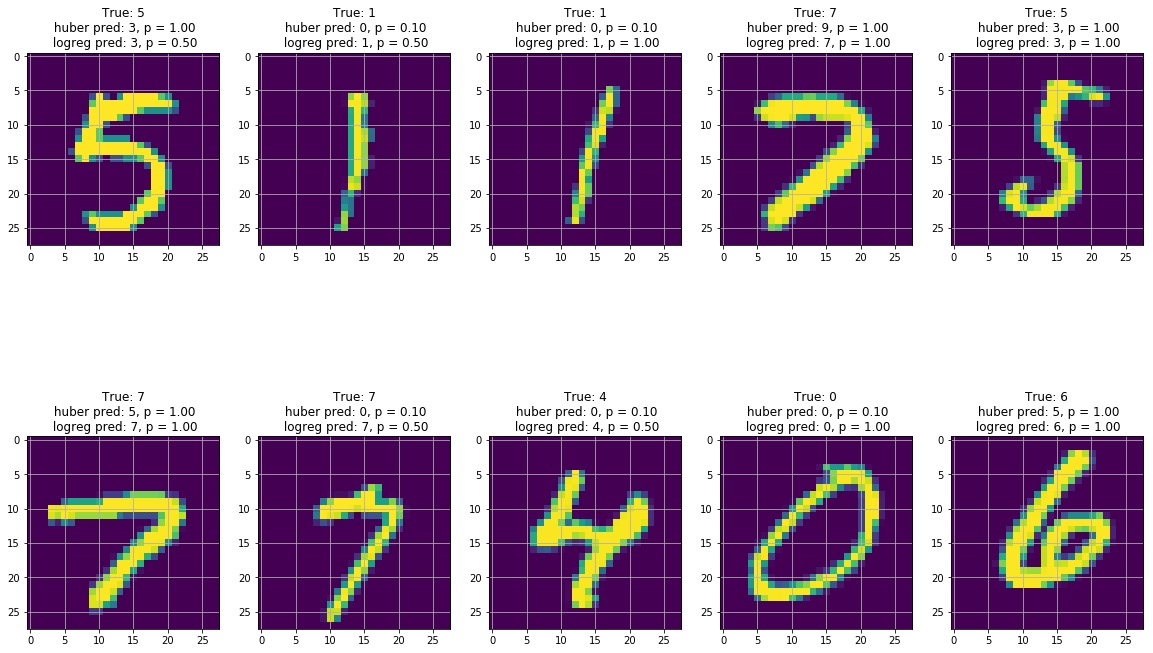

In [20]:
predictions = [huber_batch.pipeline.v('huber_predictions'), log_batch.pipeline.v('log_predictions')]
plot_images_predictions(log_batch.images, log_batch.labels, predictions,
                        classes=None, figsize=(20,20), models_names=['huber', 'logreg'])